In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # There's a PyTorch implementation but for Tensors.

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: GRID V100DX-8Q


In [3]:
embed_size = 300 # how big is each word vector
max_features = 40000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 128 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [4]:
mbti = pd.read_csv("mbti.csv")

In [5]:
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
mbti = mbti[pd.notnull(mbti['posts'])]
mbti.posts = mbti.posts.str.replace('\|\|\|', ' ')

In [7]:
mbti['len'] = mbti['posts'].apply(lambda s : len(s))

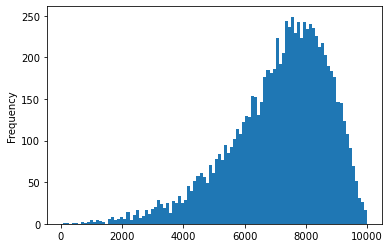

In [8]:
mbti['len'].plot.hist(bins=100)

In [9]:
count_df = mbti[['type','posts']].groupby('type').aggregate({'posts':'count'}).reset_index().sort_values('posts',ascending=False)
count_df

,type,posts
9,INFP,1832
8,INFJ,1470
11,INTP,1304
10,INTJ,1091
3,ENTP,685
1,ENFP,675
15,ISTP,337
13,ISFP,271
2,ENTJ,231
14,ISTJ,205


Targetting those above 600. The rest can be in others.

In [10]:
target_types = count_df[count_df['posts'] > 600]['type'].values

In [11]:
def types_parser(x):
    if x in target_types:
        return x
    else:
        return "OTHER"
    
mbti['type1'] = mbti['type'].apply(lambda x: types_parser(x))  

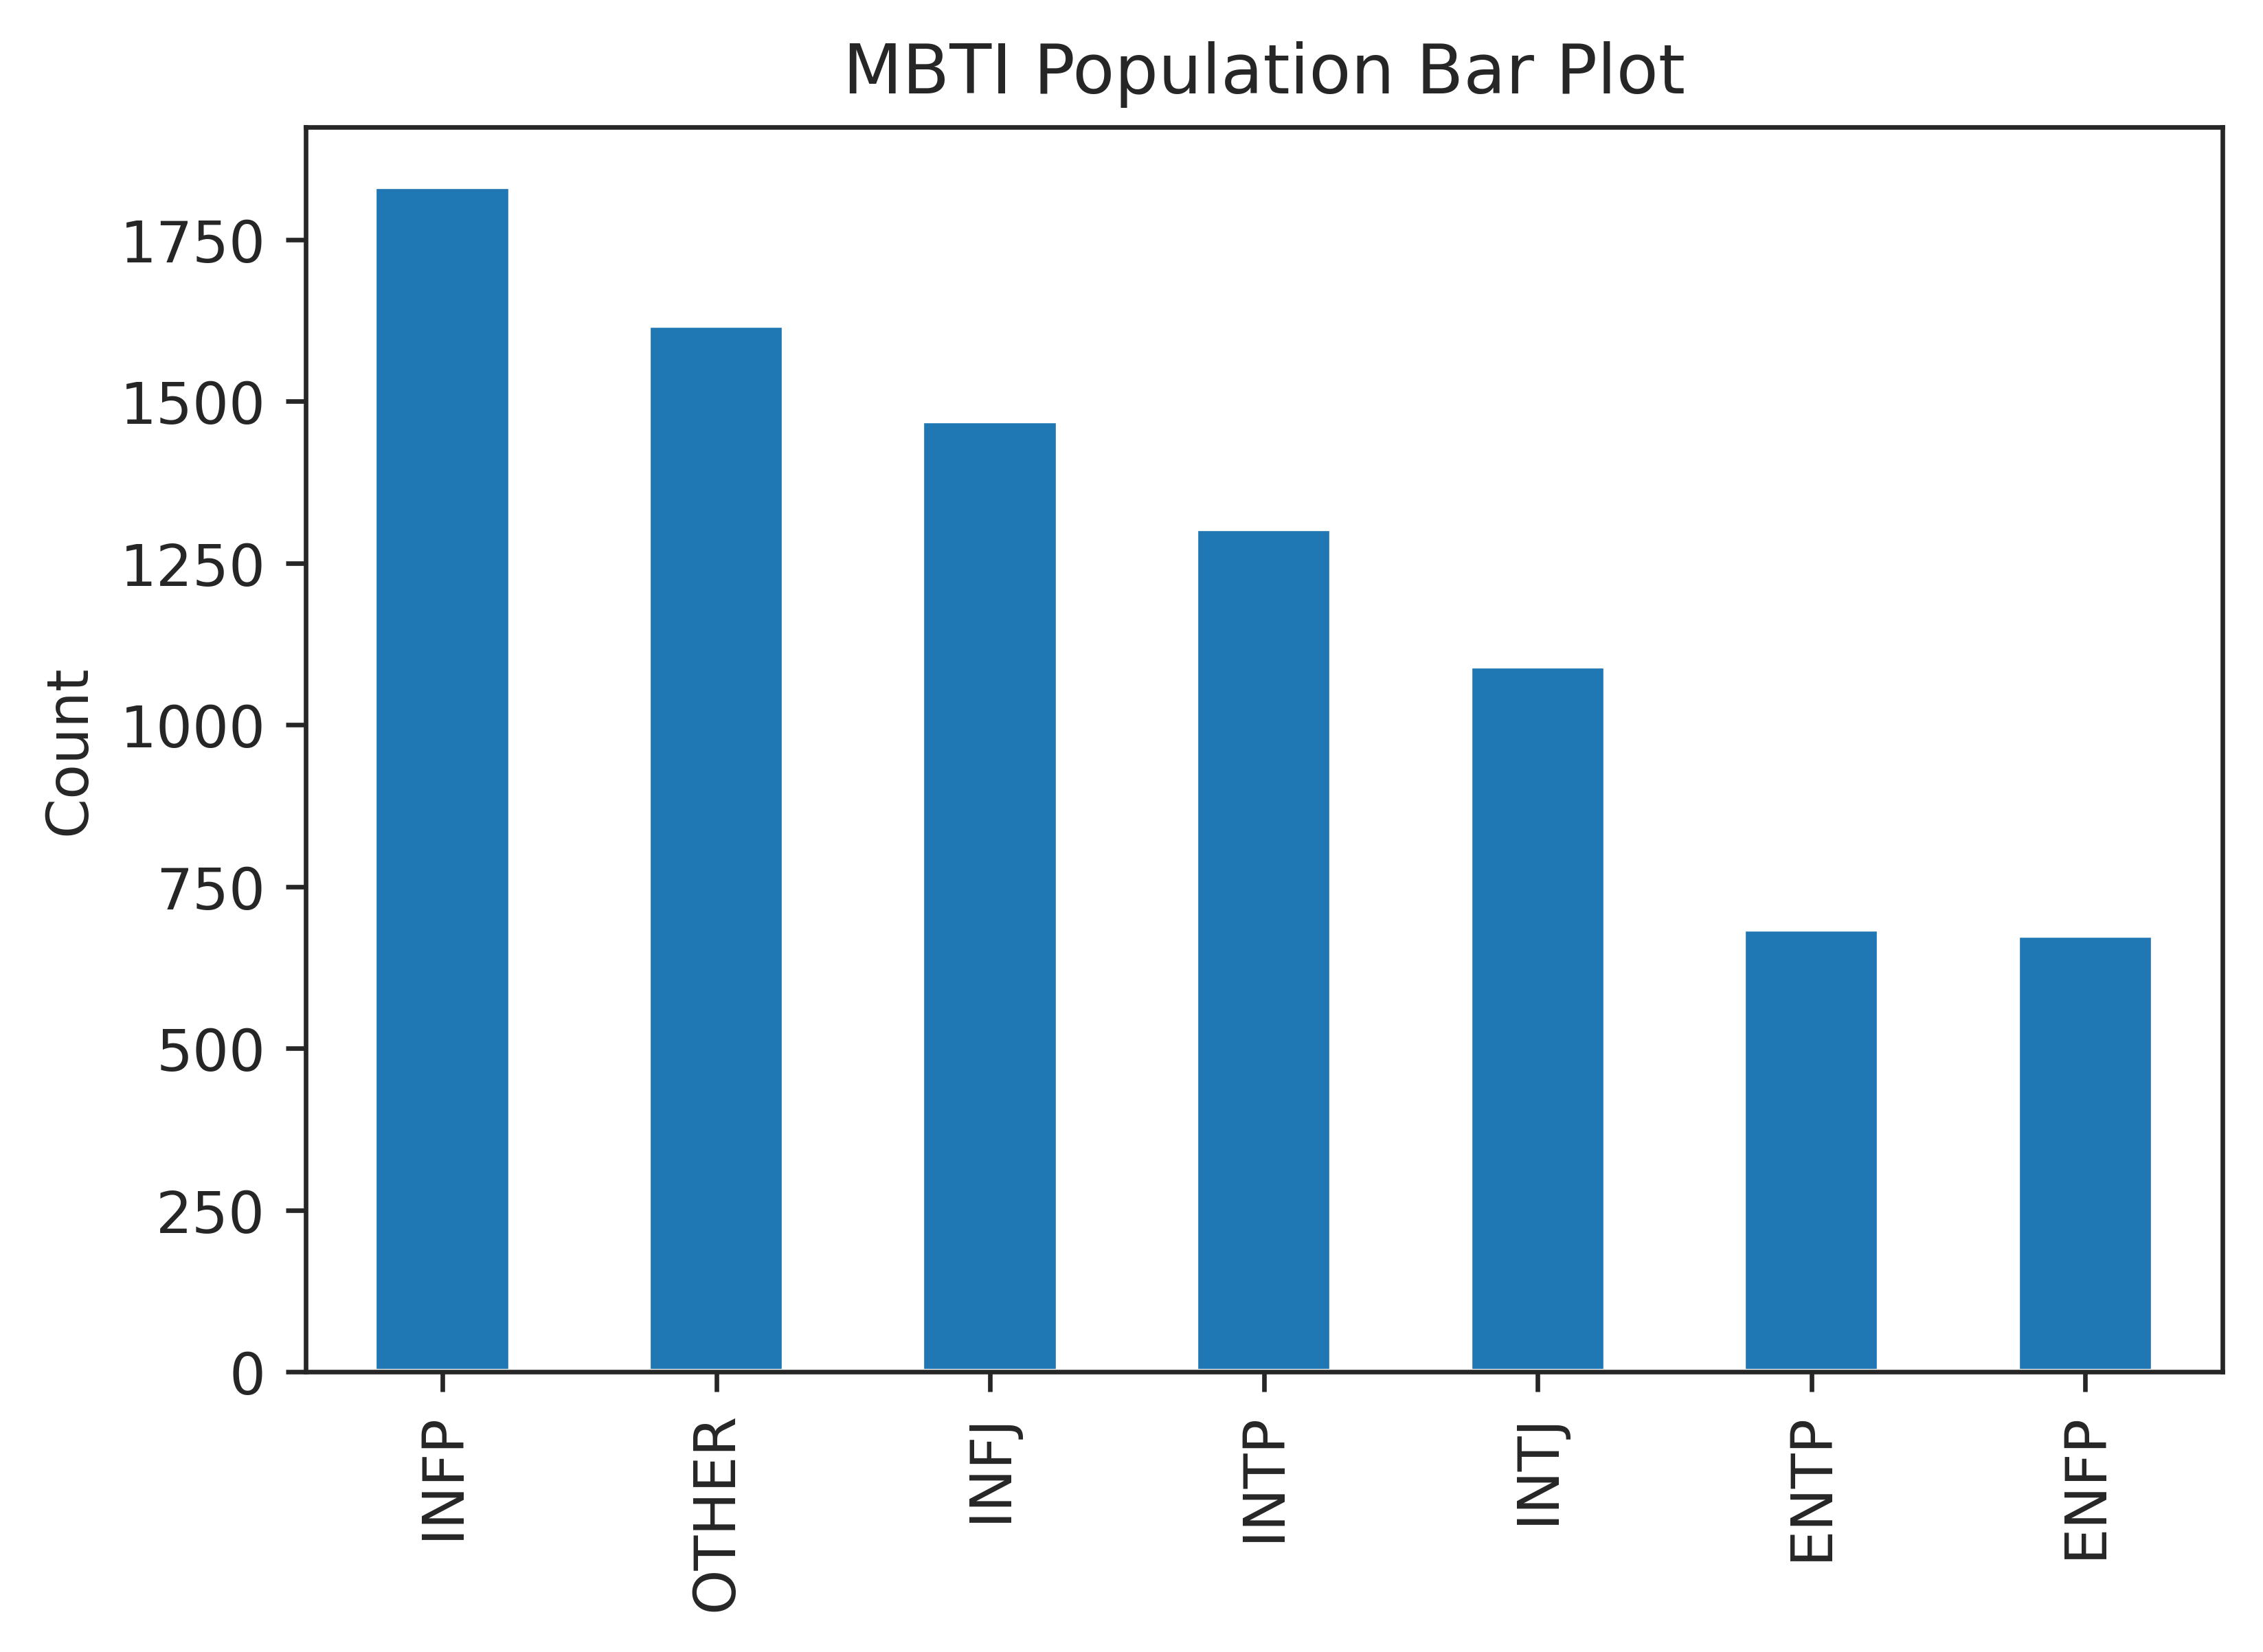

In [12]:
import seaborn as sns
sns.set_style("ticks")
plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
plt.figure(dpi=600)
plt.title("MBTI Population Bar Plot")
plt.ylabel("Count")
mbti.type.value_counts().plot.bar()

mbti.type1.value_counts().plot.bar()

We use `type` for the actual types and `type1` for the filtered types.

In [13]:
!pip install contractions

In [14]:
# Prerequisites for this function
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

def preprocessing(text):
    """Preprocessing each row of text
    
    List of things done:
    - Lower casing
    - Remove URL links
    - Remove mention/hashtags (@anonymous, #anonymous)
    - Remove accented characters (changing to ASCII from UTF-8)
    - Remove punctuations, numbers, and irrelevant characters
    - Remove excess whitespace
    - Remove stop words in English
    - Normalise and lemmatise
    - Remove single characters
    
    Possible improvements:
    - Separating words from numbers (if it exists)
    - Convert emoji and chat lingo with proper form
    

    Args:
        text (str): String of text that needs to be preprocessed
    """
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("@\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    # text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = [contractions.fix(word) for word in text.split()]
    text = ' '.join([word for word in text])
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text) # re.sub(r'[^a-zA-Z0-9]', ' ', text) if we want numeric characters
    text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
    # text = word_tokenize(text)
    # text = [token for token in text if token not in stopwords.words('english')]
    # text = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    # text = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text]
    # text = [word for word in text if len(word) > 1]
    # text = ' '.join([word for word in text])
    return text

In [15]:
mbti.posts = mbti.posts.apply(preprocessing)

In [16]:
# mbti.to_pickle(path='../datasets/mbti.pkl')

In [17]:
# mbti.posts.tolist()

In [18]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(mbti['posts'],
                                                    mbti['type'],
                                                    stratify=mbti['type'], 
                                                    test_size=0.25)

In [19]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X)
test_X = pad_sequences(test_X)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [21]:
def load_fasttext(word_index):    
    EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [22]:
embedding_matrix = load_fasttext(tokenizer.word_index)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,4,5]
        num_filters = 100
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.0)
        self.lstm = nn.LSTM(len(filter_sizes)*num_filters, 256,bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(256*2, n_classes)
            

    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        x = x.view(x.size(0),1,x.size(1))
        x,_ = self.lstm(x)
        x = x.view(x.size(0),x.size(2))
        logit = self.fc1(x) 
#         print(logit.size())
        return torch.log_softmax(logit,1)
    
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [51]:
n_epochs = 30
model = CNN_Text()
# print(model)
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
# optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()),
#                                lr=0.01,
#                                rho=0.95)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30 	 loss=219.3869 	 val_loss=217.2739  	 val_acc=0.2595  	 time=6.84s
Epoch 2/30 	 loss=215.3984 	 val_loss=212.1673  	 val_acc=0.2595  	 time=6.83s
Epoch 3/30 	 loss=202.1517 	 val_loss=185.6989  	 val_acc=0.5218  	 time=6.84s
Epoch 4/30 	 loss=163.4613 	 val_loss=147.6537  	 val_acc=0.5904  	 time=6.84s
Epoch 5/30 	 loss=133.9165 	 val_loss=128.3757  	 val_acc=0.6470  	 time=6.83s
Epoch 6/30 	 loss=118.1120 	 val_loss=117.2573  	 val_acc=0.6901  	 time=6.85s
Epoch 7/30 	 loss=107.4587 	 val_loss=109.2246  	 val_acc=0.7195  	 time=6.84s
Epoch 8/30 	 loss=100.4656 	 val_loss=106.2891  	 val_acc=0.7224  	 time=6.85s
Epoch 9/30 	 loss=96.3156 	 val_loss=102.8645  	 val_acc=0.7433  	 time=6.87s
Epoch 10/30 	 loss=91.9437 	 val_loss=100.8141  	 val_acc=0.7405  	 time=6.86s
Epoch 11/30 	 loss=88.6458 	 val_loss=100.0080  	 val_acc=0.7399  	 time=6.85s
Epoch 12/30 	 loss=85.9438 	 val_loss=98.8231  	 val_acc=0.7496  	 time=6.82s
Epoch 13/30 	 loss=83.5093 	 val_loss=98.7518  	 val_a

In [25]:
def predict_single(x):    
#     # lower the text
#     x = x.lower()
#     # Clean the text
#     x =  clean_text(x)
#     # Clean numbers
#     x =  clean_numbers(x)
#     # Clean Contractions
#     x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [26]:
x = mbti['posts'].values[100]

In [27]:
x

'rated for me it is seen in a few physical aspects of my life in my drumming and playing at parties and weddings and all of that the atmosphere of it engages something so raw inside of me i can hardly the trouble with kurzweils idea of immortality while he did propose a lot of ideas that science is supporting is the matter of semantic knowledge within technology strong ai which was proposed by oh dear i do not i cannot even predict how i would act at something like this probably going back and forth for drinks hopefully heading out to a nearby deck to enjoy the crisp air and starry how many relationships have you been in i have been in relationships but only of them were actually serious so for the further questions i will answer as if i am only thinking about those usually small and cute things random hugs gifts randomly kiss in the middle of a conversation staying up all night rugged up watching movies entwined with some coffee or alcohol or just it is definitely worthwhile finding a

In [28]:
predict_single(x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'INFP'

In [29]:
!pip install scikit-plot

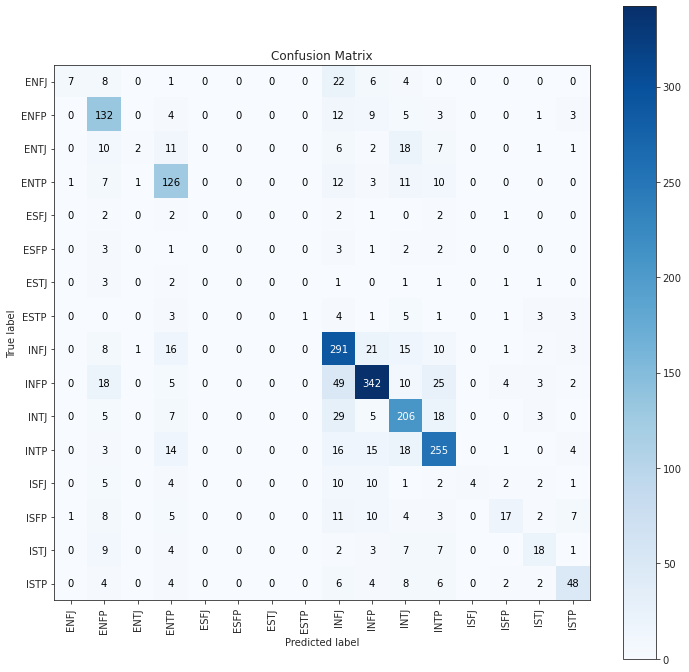

In [30]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

# Filtered Data

In [31]:
mbti_filtered = mbti.copy()

In [32]:
mbti_filtered = mbti_filtered[mbti_filtered.type1 != 'OTHER']

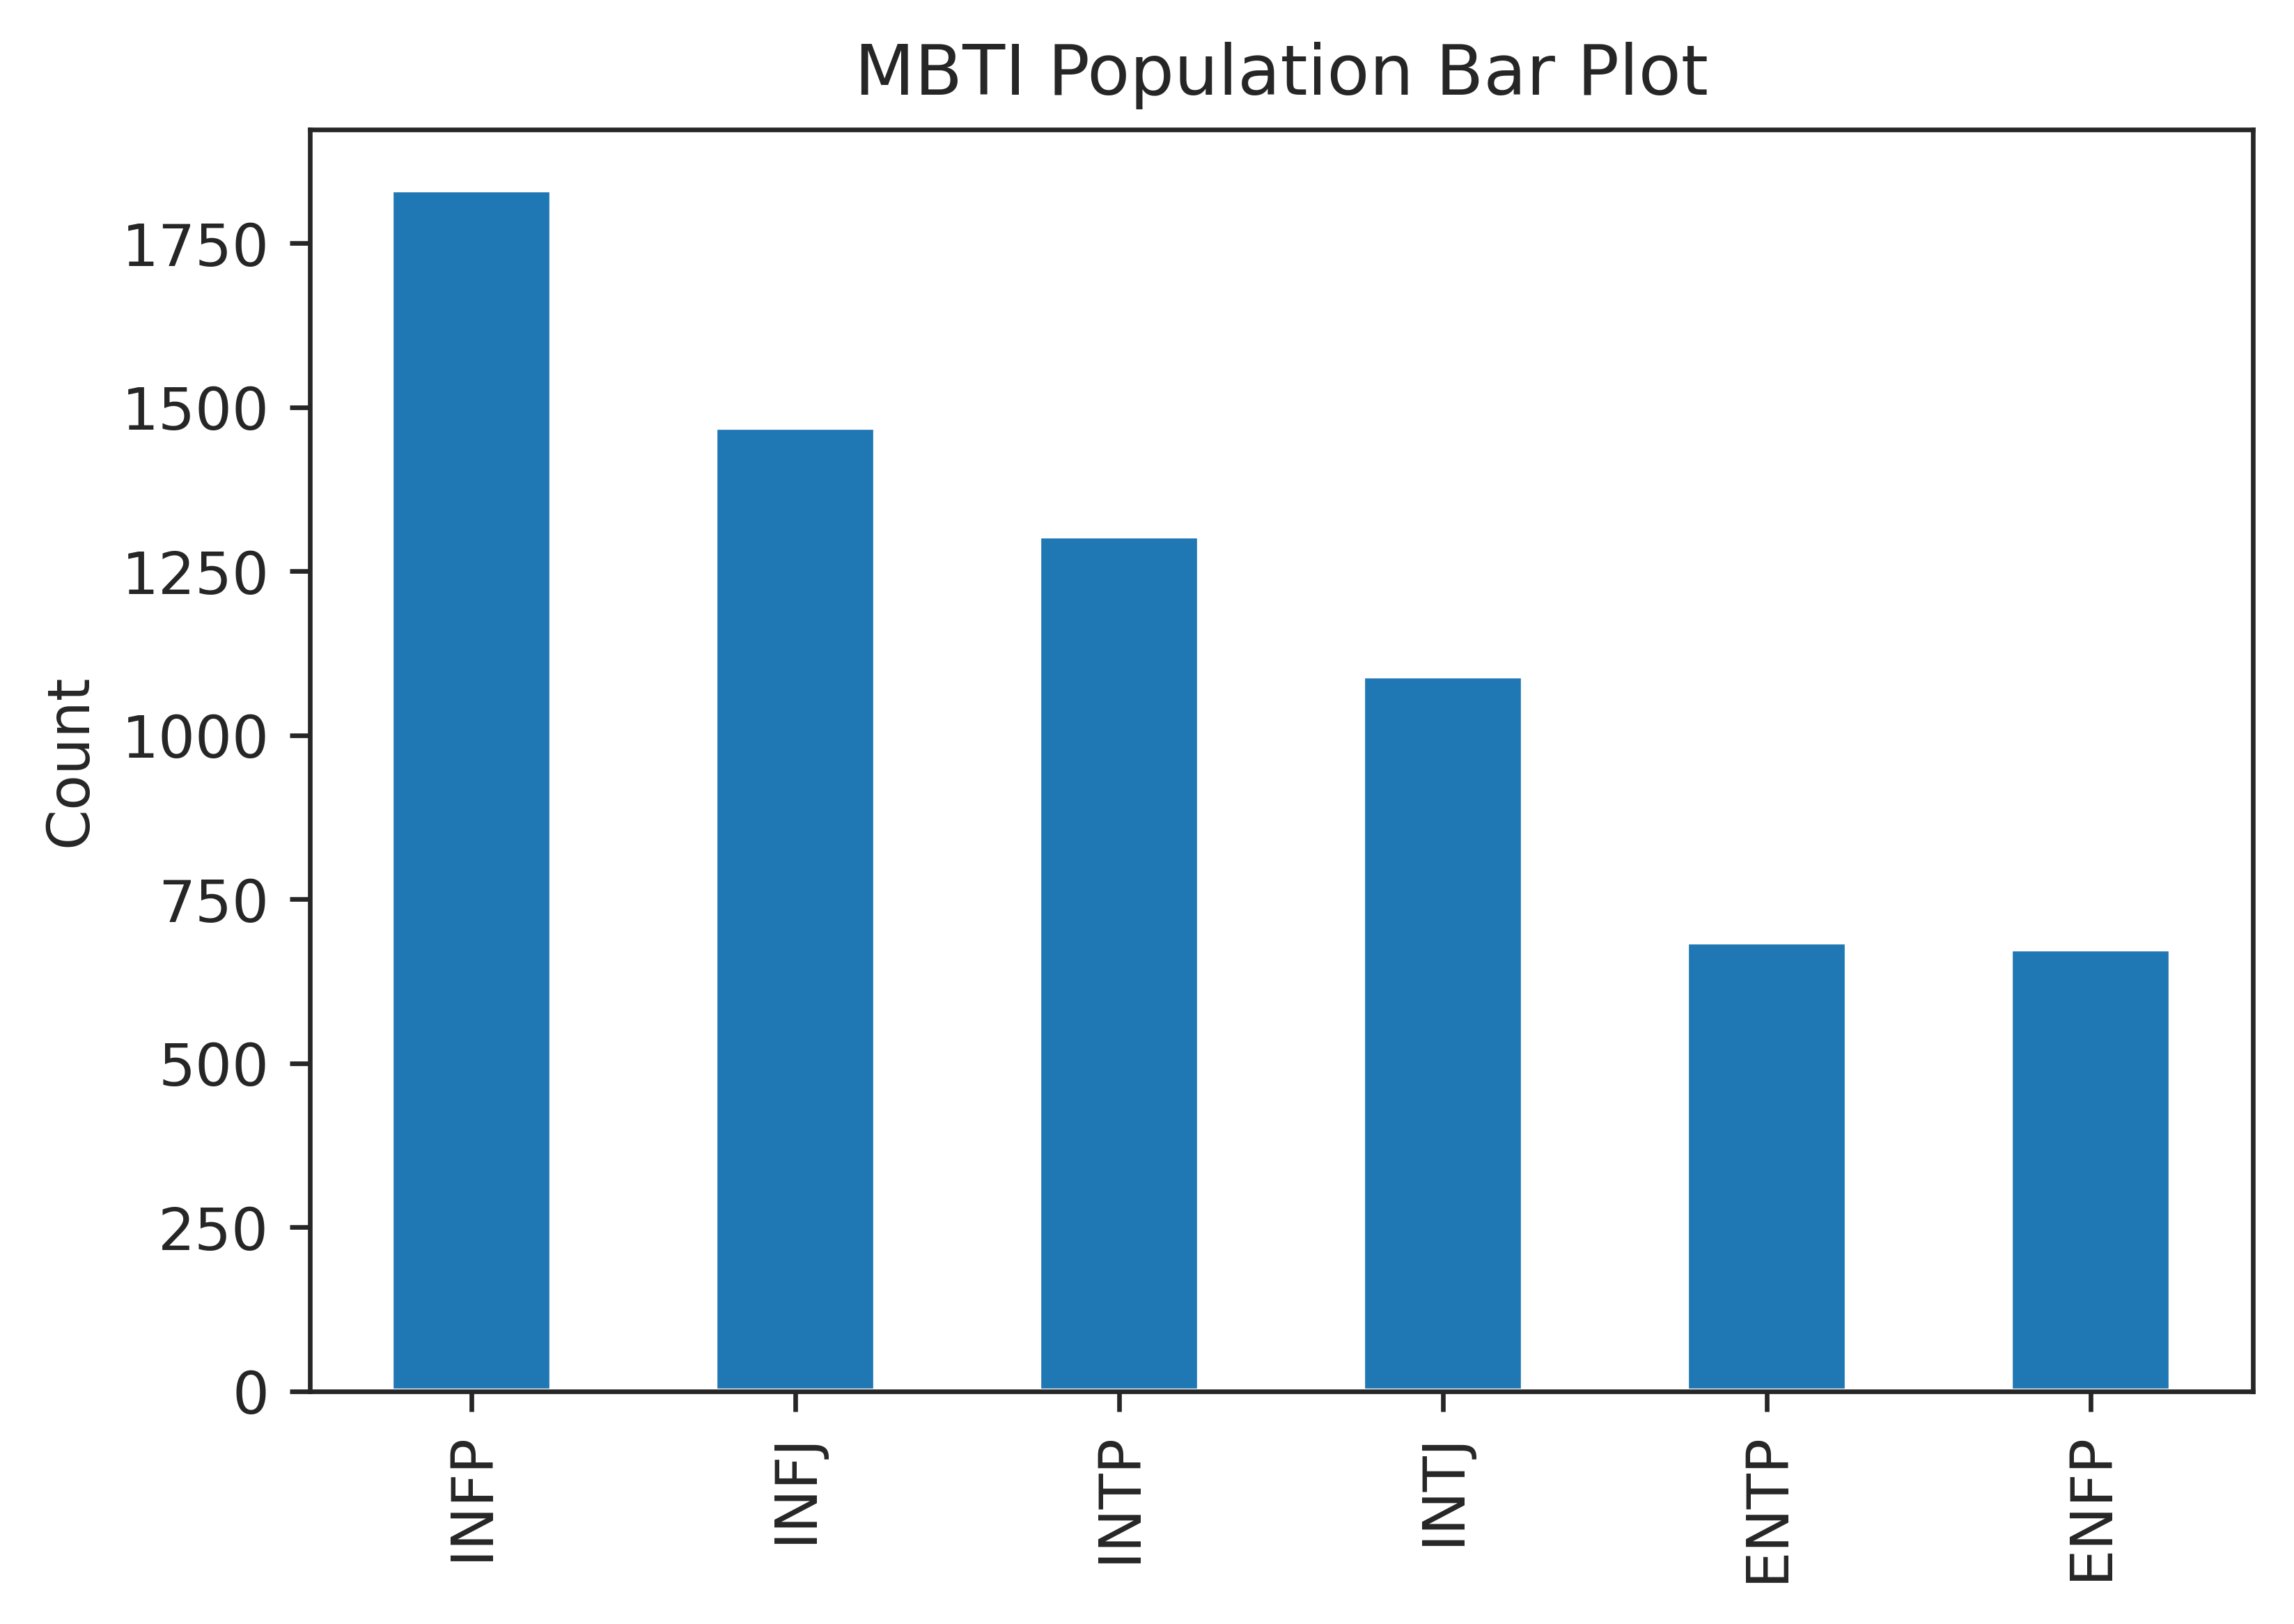

In [33]:
import seaborn as sns
sns.set_style("ticks")
plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
plt.figure(dpi=600)
plt.title("MBTI Population Bar Plot")
plt.ylabel("Count")
mbti_filtered.type.value_counts().plot.bar()

## Preprocessing

In [34]:
mbti_filtered.posts = mbti_filtered.posts.apply(preprocessing)

In [35]:
# mbti_filtered.to_pickle(path='../datasets/mbti_filtered.pkl')

# mbti_filtered = pd.read_pickle('../datasets/mbti_filtered.pkl')

## Test-train split

In [36]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(mbti_filtered['posts'],
                                                    mbti_filtered['type'],
                                                    stratify=mbti_filtered['type'], 
                                                    test_size=0.25)

## Tokenise and label

In [37]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X)
test_X = pad_sequences(test_X)

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

# Word embedding

From [this notebook](https://www.kaggle.com/gmhost/gru-capsule/notebook).

In [39]:
def load_fasttext(word_index):    
    EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [40]:
embedding_matrix = load_fasttext(tokenizer.word_index)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
len(embedding_matrix[0])

300

In [42]:
train_X.shape

(5292, 2005)

In [52]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,4,5]
        num_filters = 100
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.0)
        self.lstm = nn.LSTM(len(filter_sizes)*num_filters, 256, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(256*2, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        x = x.view(x.size(0),1,x.size(1))
        x,_ = self.lstm(x)
        x = x.view(x.size(0),x.size(2))
        logit = self.fc1(x) 
#         print(logit.size())
        return torch.log_softmax(logit,1)

In [54]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()),
#                                lr=0.01,
#                                rho=0.95)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 	 loss=190.6933 	 val_loss=146.6860  	 val_acc=0.5841  	 time=6.85s
Epoch 2/10 	 loss=114.6096 	 val_loss=103.3064  	 val_acc=0.7303  	 time=6.82s
Epoch 3/10 	 loss=87.1503 	 val_loss=98.3756  	 val_acc=0.7530  	 time=6.83s
Epoch 4/10 	 loss=66.0161 	 val_loss=92.2725  	 val_acc=0.7762  	 time=6.80s
Epoch 5/10 	 loss=45.7666 	 val_loss=100.1764  	 val_acc=0.7620  	 time=6.80s
Epoch 6/10 	 loss=25.3997 	 val_loss=105.3408  	 val_acc=0.7626  	 time=6.82s
Epoch 7/10 	 loss=13.1184 	 val_loss=118.2536  	 val_acc=0.7524  	 time=6.83s
Epoch 8/10 	 loss=7.0787 	 val_loss=125.2069  	 val_acc=0.7768  	 time=6.82s
Epoch 9/10 	 loss=3.3071 	 val_loss=125.3502  	 val_acc=0.7626  	 time=6.83s
Epoch 10/10 	 loss=1.6968 	 val_loss=130.0533  	 val_acc=0.7700  	 time=6.83s


In [55]:
torch.save(model,'textcnn_model_50_epochs')

In [56]:
import seaborn as sns
def plot_graph(epochs):
    plt.figure(figsize=(12,12), dpi=600)
    sns.set_style("ticks")
    plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

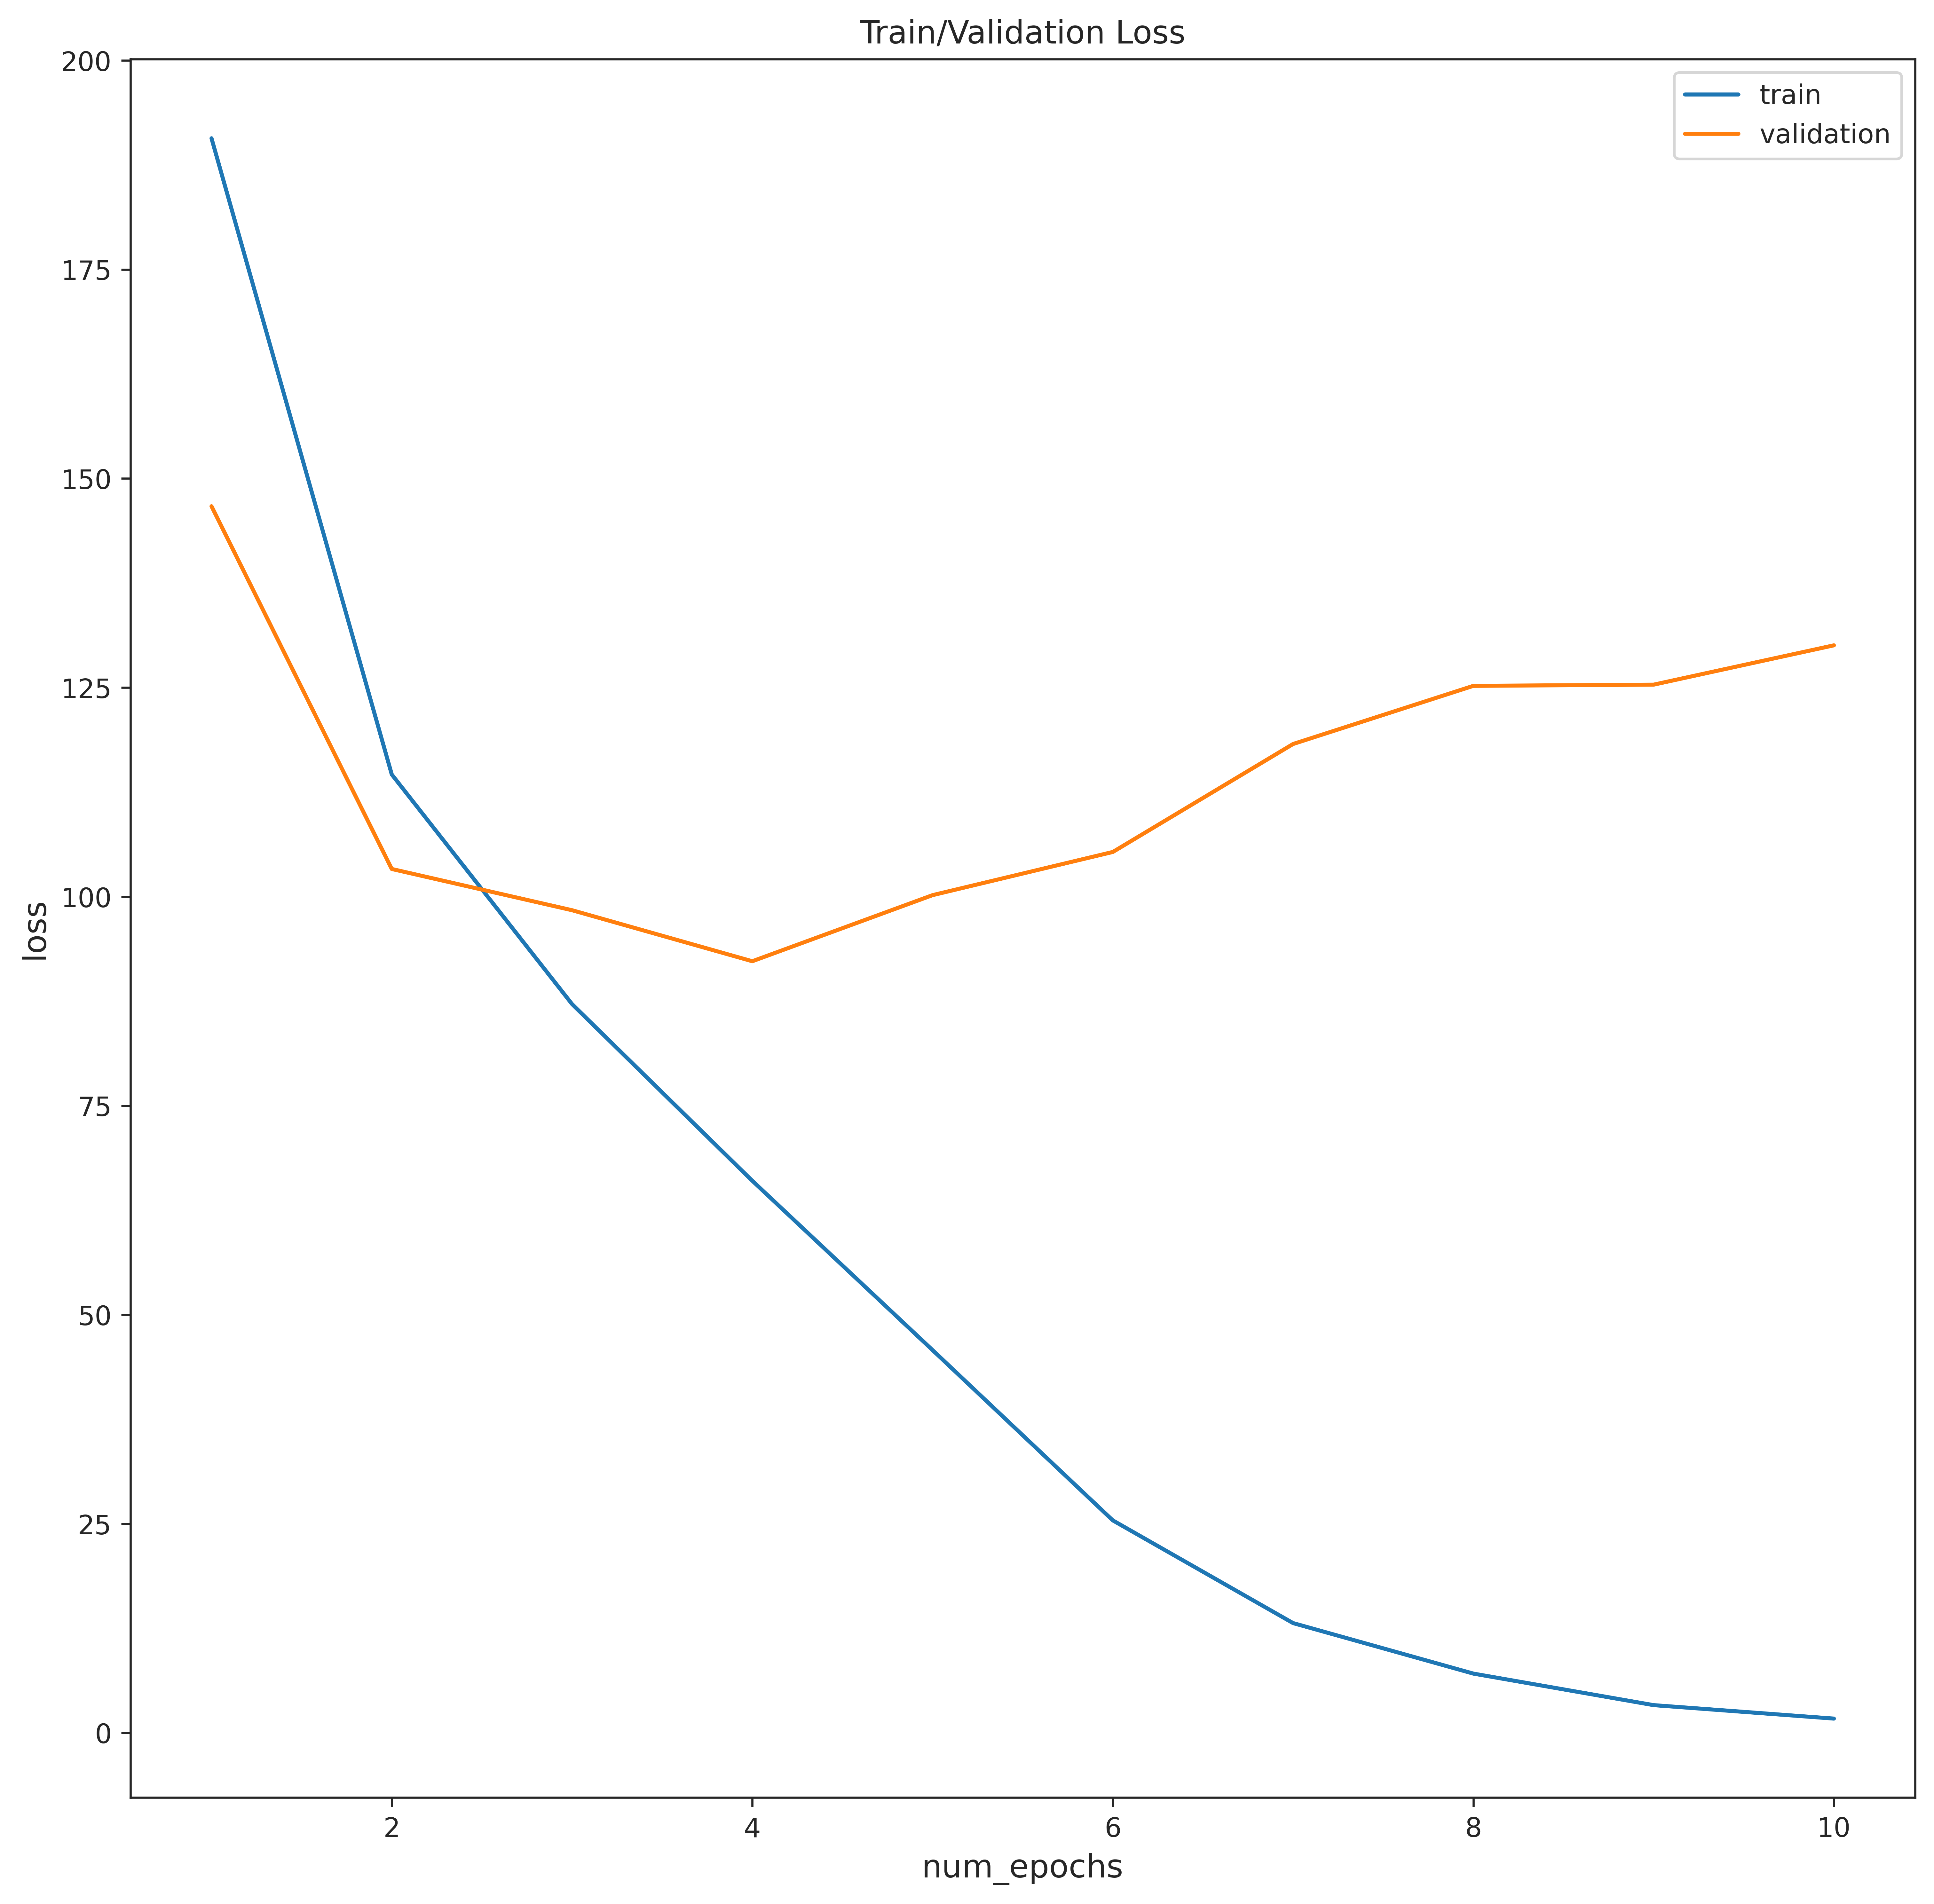

In [57]:
plot_graph(n_epochs)

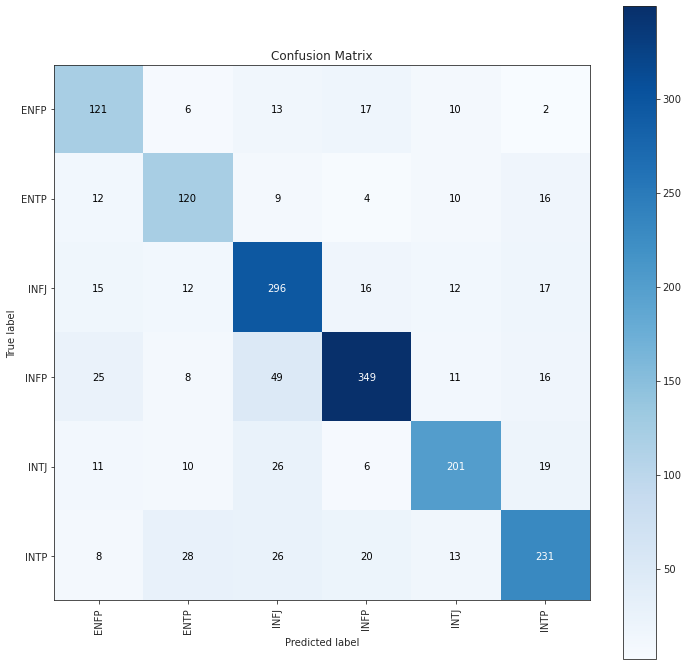

In [48]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        ENFP       0.63      0.72      0.67       169
        ENTP       0.65      0.70      0.68       171
        INFJ       0.71      0.80      0.75       368
        INFP       0.85      0.76      0.80       458
        INTJ       0.78      0.74      0.76       273
        INTP       0.77      0.71      0.74       326

    accuracy                           0.75      1765
   macro avg       0.73      0.74      0.73      1765
weighted avg       0.75      0.75      0.75      1765

